<div style="text-align:center">
  <h1>Reducing Estimation Errors in Forecast Combination: Covariance Matrix Estimation and Trimming Methods</h1>
  <h3>Yannick van Etten (2688877)</h3>
  <h3>Bachelor Thesis Econometrics and Operations Research</h3>
  <h3>Thesis commission: Dr. L. Hoesch  (supervisor) and Xia Zou  (co-reader)</h3>
</div>


<div style="text-align:center">
  <h4>Simulation study Radchenko et al. (2023)</h4>
</div>

This Jupyter Notebook is part of the bachelor thesis by Yannick van Etten. Several methods are evaluated to reduce the estimation errors. In Radchenko et al. (2023), a trimming method is evaluated in detail. In the thesis, this will be replicated. This Notebook focuses on Figure 6 from Radchenko et al. (2023), where the mean squared forecasting error (MSFE) of a forecast combination is plotted conditional of a trimming threshold. In addition, their paper looks at the impact of fixed weights on the MSFE. Lastly, this Notebook recreates Figure 7 from Radchenko et al. (2023). In this plot, the MSFE of a forecast combination is plotted conditional to a trimming threshold, similar to Figure 6. However, this time this is done for different AR(1) time series, changing the autoregressive parameter $\phi_1$. The theory used in the simulation study will be added to illustrate how the study is conducted.

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<div style="text-align:center">
  <h3>General theory and functiond for the simulation study</h3>
</div>

In this simulation study, a time series is generated based on an AR(1) process:
$$
z_t = \phi_1 z_{t-1}+\eta_t \quad\quad t=1,\dots,T+1
$$
The error ${\eta_t}$ are independent and identically distributed from a standard normal distribution. The parameter $\phi_1$ is chosen to satisfy $|\phi_1|<1$. In total, $n$ time series will be generated. To improve the simulation's efficiency, create one matrix containing all the time series of length $T+1$ at one time.

In [143]:
def simulate_ar1(phi,T,n):
    """
    Simulate an autoregressive process of order 1 (AR(1))
    Input:
        phi (float): The autoregressive coefficient.
        T (int): The number of observations used to estimate the weights used in the forecast combination for T+1.
        n (int): The number of simulations.
    Returns:
        ar (ndarray): An array of shape (n, T+1) containing the simulated AR(1) process.
    """
    ar = np.zeros((n, T+1))
    seed_value = 777
    np.random.seed(seed_value)
    ar[:,0] = np.random.normal(0,1, size=n)  # set initial values
    for t in range(1, T+1):
        ar[:, t] = phi*ar[:,t-1]+np.random.normal(0,1,size=n)
    return ar

In this simulation two forecasters have a forecast for $T+1$. As is indicated in Radchenko et al. (2023). The forecasts are determined by:
\begin{align*}
y_1 &= z_T && \quad\quad\quad y_2 = \rho_2 z_{T-1}
\end{align*}

where the first two autocorrelation coefficients are used and given by:
\begin{align*}
    \rho_1 &= \text{corr}(z_t,z_{t-1}) = \phi_1 &&\quad\quad\quad  \rho_2 = \text{corr}(z_t,z_{t-2}) = \phi_1^2
\end{align*}
The two forecast of $z_{T+1}$ are determined the observations $z_T$ and $z_{T-1}$.

In [144]:
def calc_forecasts(z,rho2):
    """
    Calculates forecasts based on the given forecast process.

    Input:
        z (numpy.ndarray): Array containing all the time series observations.
        rho2 (float): second autocorrelation coefficient.

    Returns:
        tuple: A tuple containing the forecasts, y1 and y2, for T+1.

    """
    return np.array([z[-1] for z in z]), rho2*np.array([z[-2] for z in z])

The simulation study aims to create a combination of both forecasts for the time series observation at $T+1$.

The weights have to be estimated to obtain the forecast combination. The weights are estimated using the first $T$ observations. The errors are defined as $e_{1t}=z_{t}-z_{t-1}$ and $e_{2t}=z_{t}-\rho_2 z_{t-2}$. This leads to forecast errors:
\begin{align*}
    e_1 &= e_{1,T+1}=z_{T+1}-y_1 && \quad\quad\quad e_2 = e_{2,T+1}=z_{T+1}-y_2\\
    e_1 &=z_{T+1}-z_T && \quad\quad\quad e_2=z_{T+1}-\rho_2 z_{T-1}
\end{align*}
In the simulation, the covariance matrix will be estimated by the sample covariance matrix, $\widehat{\Sigma}$, following Radchenko et al. (2023). The error means are defines as: $\overline{e_1}=\frac{1}{T-2}\sum\nolimits^{T-1}_{t=2}e_{1,t+1}$ and $\overline{e_2}=\frac{1}{T-2}\sum\nolimits^{T-1}_{t=2}e_{2,t+1}$. With these error means, the sample covariance matrix is calculated as:

$\widehat{\Sigma} = \begin{pmatrix}
    \widehat{\sigma}_1^2 & \widehat{\rho}\widehat{\sigma}_1\widehat{\sigma}_2 \\
    \widehat{\rho}\widehat{\sigma}_1\widehat{\sigma}_2 & \widehat{\sigma}_2^2
\end{pmatrix} = \frac{1}{T-3}\times \sum\limits^{T-1}_{t=2} \begin{pmatrix}
    (e_{1,t+1}-\overline{e_1})^2 & (e_{1,t+1}-\overline{e_1})(e_{2,t+1}-\overline{e_2}) \\
    (e_{1,t+1}-\overline{e_1})(e_{2,t+1}-\overline{e_2}) & (e_{2,t+1}-\overline{e_2})^2
\end{pmatrix}
$

With the sample covariance matrix the the theoretically optimal weight $w^*$ is estimated by:

$\widehat{w}$ as:
$ \widehat{w}=\frac{\widehat{\sigma}_2^2-\widehat{\rho}\widehat{\sigma}_1\widehat{\sigma}_2}{\widehat{\sigma}_1^2+\widehat{\sigma}_2^2-2\widehat{\rho}\widehat{\sigma}_1\widehat{\sigma}_2}
$

It is important to note that there are $T$ observations. Observation 1 cannot be used since the second forecast is based on $z_{t-1}$, and no observation is available at time 0. Therefore $T-2$ forecast observations are used to determine the weights.

In [145]:
def calc_weights(z,rho2,T):
    """
    Calculates weights for forecast combination using T-2 forecast performance observations.

    Input:
        z (numpy.ndarray): Array containing the time serie observations.
        rho2 (float): second autoregressive autocorrelation squared.
        T (int): Number of observations in the process.

    Returns:
        numpy.ndarray: Array containing the calculated weights for all n time series

    """
    e1t = z[:,2:T] - z[:,1:T-1]
    e2t = z[:,2:T] - rho2 * z[:,:T-2]
    e1_bar = np.mean(e1t,axis=1)
    e2_bar = np.mean(e2t,axis=1)
    sigma_e1 = np.sum(np.power(e1t-e1_bar[:,np.newaxis],2), axis=1)/(T-3)
    sigma_e2 = np.sum(np.power(e2t-e2_bar[:,np.newaxis],2), axis=1)/(T-3)
    p1 = (e1t-e1_bar[:, np.newaxis])
    p2 = (e2t-e2_bar[:, np.newaxis])
    cov_e1_e2 = np.sum(p1*p2, axis=1)/(T-3)
    w = (sigma_e2-cov_e1_e2)/(sigma_e1+sigma_e2-2*cov_e1_e2)
    return w

Given the weights, the forecast combination can be determined by:
\begin{align*}
    y_c = \widehat{w}y_1+(1-\widehat{w})y_2
\end{align*}


In [146]:
def calc_comb_forecast(y1,y2,w):
    """
    Combines forecasts given the estimated optimal weights.

    Input:
        y1 (numpy.ndarray): Array of forecasts from the first model.
        y2 (numpy.ndarray): Array of forecasts from the second model.
        w (float): Weight for combining the forecasts.

    Returns:
        numpy.ndarray: Array containing the combined forecasts.

    """
    yc = w*y1+(1-w)*y2
    return yc

Given the previous theory and functions, it becomes possible to determine the MSFE values of all n time series given a certain trimming threshold c. First, the data $z$ is simulated. The value $z_{T+1}$ is extracted from this $z$ to $z_f$. This $z_f$ is the true value that needs to be forecasted by the remaining observations and is deleted from $z$.

Given $z$, the two individual forecasts, $y_1$ and $y_2$ for $T+1$, are derived. The weights are also determined by the $z$ matrix.

Given these values, it becomes possible to determine the Mean Squared Forecast Error (MSFE) of the forecast combination. The combination is determined by the weights trimming by threshold $c$. Since there are two forecasts, the trimming methods discussed in the thesis will result in the same weight. Therefore, the weights are determined by:
$$
w^{\text{TR}}(c)=\text{max}(\widehat{w},c)=\left\{
\begin{aligned}
    \widehat{w}&, \quad \widehat{w}> c \\
    c&, \quad \widehat{w}\leq c
\end{aligned}
\right.
$$
The for-loop determines the MSFE values for different threshold values.


In [147]:
def calc_msfe(c,phi,T,n):
    """
    Calculates MSFE value conditional on the trimming threshold c.

    Input:
        c (numpy.ndarray): Array of trimming threshold values.
        phi (float): Autoregressive parameter for the AR(1) process.
        T (int): Number of time periods.
        n (int): Number of simulations.

    Returns:
        tuple: A tuple containing the following:
            - Vmsfe (numpy.ndarray): Array of MSFE values for different weights.
            - w (numpy.ndarray): Array of calculated weights.
            - w_trimmed (numpy.ndarray): Array of trimmed weights.
            - zf (list): List of observations at T+1 from the AR(1) process that need to be forecasted.
            - y1 (numpy.ndarray): Forecasts for T+1 by method 1.
            - y2 (numpy.ndarray): Forecasts for T+1 by method 1.
    """
    rho2 = phi**2
    z = simulate_ar1(phi, T, n)
    zf = [z[-1] for z in z]
    z = np.delete(z, -1, axis=1)
    y1, y2 = calc_forecasts(z, rho2)
    w = calc_weights(z,rho2,T)
    Vmsfe = np.empty(len(c))
    for i in range(len(c)):
        w_trimmed = np.where(w<c[i],c[i], w)
        yc = calc_comb_forecast(y1,y2,w_trimmed)
        error = np.power((zf-yc),2)
        Vmsfe[i] = np.mean(error)
    return Vmsfe,w,w_trimmed,zf,y1,y2

<div style="text-align:center">
  <h3>Figure 6 of Radchenko et al. (2023)</h3>
</div>

Till now, all global functions have been properly defined. Using these functions, it is possible to recreate Figure 6 by following Radchenko et al. (2023). The MSFE will be determined for a setting where the autoregressive parameter for the AR(1) process is set to $\phi_1 = -0.5$ since in the thesis is established that the optimal weight is negative when $\rho > \frac{\sigma_2}{\sigma_1}$. This holds for all $\phi_1<0$. 

Furthermore, following Radchenko et al. (2023), the number of observations will be set at $30$, so $T=30$. The MSFE will be evaluated for trimming thresholds $c$ between $-0.6$ and $0$. The number of simulations is set at $n=1000000$ in order to control the simulation error. Lastly, as seen before, $\rho_1 = \phi_1$ and $\rho_2 = \phi_1^2$. This results to: 

- $\phi_1 = -0.5$
- $T = 30$
- $-0.6<c<0$
- $n = 1000000$
- $\rho_1 = \phi_1$
- $\rho_2 = \phi_1^2$



In [158]:
phi = -0.5

T = 30
c = np.linspace(-0.6, 0, 61)
n = 1000000

Vmsfe,w,w_trimmed,zf,y1,y2 = calc_msfe(c,phi,T,n)

To illustrate the impact of the trimming method on the MSFE of the forecast combination, this is plotted. In this plot, the black line indicated the MSFE as a function of the threshold value $c$. The red vertical line represents the optimal trimming threshold leading to the smallest MSFE value. This value is also printed.

In [196]:
def plot_msfe(Vmsfe,c, c_star):
    """
    Plots the MSFE values conditional on threshold values.
    The black line indated the MSFE values. The red horizontal line
    the optimal threshold value.

    Input:
        Vmsfe (numpy.ndarray): Array of MSFE values for different threshold.
        c (numpy.ndarray): Array of theshold.
        c_star (float): Optimal threshold value.

    Returns:
        None

    """
    fig, ax = plt.subplots()
    ax.plot(c, Vmsfe, '-k')  # black line
    ax.axvline(c_star, color='red')  # red vertical line
    ax.set_xlabel('$C$',fontsize=16)
    ax.set_ylabel('MSFE',fontsize=16)
    plt.xlim(-0.6, 0)
    plt.ylim(1.11, 1.25)
    ticks_x = np.linspace(-0.6, 0, 7)
    ticks_y = np.linspace(1.1, 1.25, 4)
    plt.xticks(ticks_x,fontsize=13)
    plt.yticks(ticks_y,fontsize=13)
    plt.title('MSFE Plot',fontsize=18)
    #plt.savefig('MSFE_Plot.png', dpi=300)
    plt.show()
    

Optimal trimming threshold: -0.26


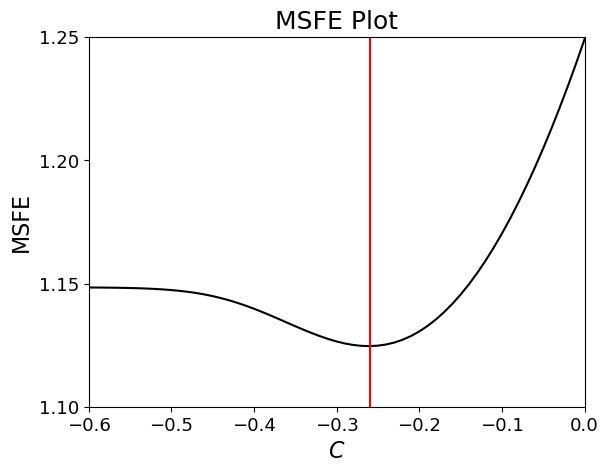

In [195]:
min_MSFE_index = np.argmin(Vmsfe)
c_star = c[min_MSFE_index]
print('Optimal trimming threshold:',round(c_star,2))
plot_msfe(Vmsfe,c, c_star)

This plot is evaluated in detail in the thesis.

The density of the estimated untrimmed weights is also of interest. In the current code, a vector of these weights is returned and can be used. The weights are currently estimated, but it is also possible to use fixed weights. A fixed means the weight is set to a specific value without estimation. It is of interest to see the MSFE function given a fixed weight. 

In the previous code, a matrix containing all values $z_{T+1}$ is returned by rf. The aim is to forecast these values by combining the individual forecasts $y_1$ and $y_2$. These vectors are also returned in the previous code. This makes it possible to determine the MSFE of the combination using fixed weights with the same data as before. 

For weights between $-0.5$ and $1$, the MSFE value of the forecast combination using this fixed weight is determined. All these values are stored and returned. This also ensures that if the weight is fixed at $0$, the MSFE value of using only the second forecast is calculated, indicated by $\sigma_2$ in the plot. Similarly, a fixed weight of $1$ represents the MSFE value using only the first forecast, indicated by $\sigma_1$ in the plot. The MSFE of the theoretical optimal weight of $-0.29$ is represented by point F.

In [163]:
def calc_msfe2(zf, y1, y2):
    """
    Calculates the MSFE based on given forecasts.

    Input:
        zf (array): Array of observations that need to be forecasted
        y1 (array): Array of forecasts for T+1 from the first model.
        y2 (array): Array of forecasts for T+1 from the second model.

    Returns:
        w_msfe(array): Array containing weight values and corresponding MSFE values.

    """
    w_msfe = np.zeros((151, 2))
    # Generate equally spaced weight values from -0.5 to 1 with a step size of 0.01
    w_msfe[:, 0] = np.linspace(-0.5,1,num=151, endpoint=True)
    for i in range(len(w_msfe)):
        yc = calc_comb_forecast(y1,y2,w_msfe[i, 0])
        error = np.power((zf-yc), 2)
        w_msfe[i, 1]=np.mean(error)
    return w_msfe

In [164]:
w_msfe = calc_msfe2(zf,y1,y2)

In [201]:
def plot_density(w,c_star,w_msfe):
    """
    Plots the density plot for weights and MSFE values.

    Input:
        w (numpy.ndarray): Array of threshold values.
        c_star (float): Optimal estimated theshold value.
        w_msfe (numpy.ndarray): Array of MSFE values for different thresholds.

    Returns:
        None
    """
    sns.kdeplot(w, linestyle='--', color='green')
    plt.axvline(x=c_star, color='red')
    plt.plot(w_msfe[:,0],w_msfe[:,1],color='blue', linewidth=2,)
    indices_opt = 21  # when fixed weight is set at -0.29 (opt_w)
    indices_0 = int(np.where(w_msfe[:,0] == 0)[0])  # when fixed weight is set at 0
    indices_1 = int(np.where(w_msfe[:,0] == 1)[0])  # when fixed weight is set at 1
    x_values = [w_msfe[indices_opt, 0], w_msfe[indices_0,0], w_msfe[indices_1,0]]
    labels = ['F', '$\sigma_2^2$', '$\sigma_1^2$']
    y_values = [w_msfe[24, 1], w_msfe[50, 1], w_msfe[150, 1]]
    plt.scatter(x_values, y_values, color='turquoise', s=40, zorder=3)
    plt.text(x_values[0]-0.07, y_values[0]-0.3,labels[0],fontsize=14,color='black')
    plt.text(x_values[1]+0.03, y_values[1]-0.2,labels[1],fontsize=14,color='black')
    plt.text(x_values[2]+0.003, y_values[2]-0.3,labels[2],fontsize=14,color='black')
    plt.xlim(-1,1)
    plt.ylim(0,4)
    ticks_x = np.linspace(-1,1,5)
    ticks_y = np.linspace(0,4,9)
    plt.xticks(ticks_x,fontsize=13)
    plt.yticks(ticks_y,fontsize=13)
    plt.title('Density Plot',fontsize=18)
    plt.xlabel('$w$',fontsize=16)
    plt.ylabel('MSFE',fontsize=16)
    #plt.savefig('Density_Plot.png', dpi=300)
    plt.show()

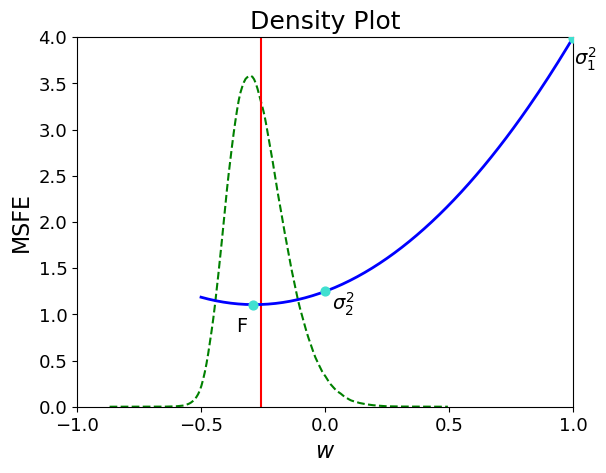

In [200]:
plot_density(w,c_star,w_msfe)

This plot is evaluated in detail in the thesis.

<div style="text-align:center">
  <h3>Figure 7 of Radchenko et al. (2023)</h3>
</div>

Previously, a MSFE plot of the forecast combination was created. Where the timeserie generated by an AR(1) process and the autoregressive parameter is set to $\phi_1=−0.5$. However, the influence of this $\phi$ parameter on the MSFE plot is also interesting to see. This is illustrated in Figure 7. 

In the thesis, it is established that the optimal weight is negative when $\rho > \frac{\sigma_2}{\sigma_1}$. This holds for all $\phi_1<0$. The $\phi$ parameter is therefore now set at values between $-0.9$ and $0$, with a $0.1$ stepsize. For each value, the MSFE values are determined. Eventually, these are plotted in two separate plots to improve clarity. The blue dot indicates the optimal trimming threshold. Furthermore, the same number of simulations is used. Furthermore, the trimming threshold is now between $-0.7$ and $0$. So:

- $-0.7\leq \phi_1 \leq0$
- $T = 30$
- $-0.7<c<0$
- $n = 1000000$

In [167]:
def calc_msfe3(c,phi,T,n):
    """
    Calculates MSFE value conditional on the trimming threshold c given a value phi.

    Input:
        c (numpy.ndarray): Array of trimming threshold values.
        phi (float): Autoregressive parameter for the AR(1) process.
        T (int): Number of time periods.
        n (int): Number of simulations.

    Returns:
        tuple: A tuple containing the following:
            - Vmsfe (numpy.ndarray): Array of MSFE values for different weights.
            - w (numpy.ndarray): Array of calculated weights.
    """
    rho2 = phi**2
    z = simulate_ar1(phi,T,n)
    zf = [z[-1] for z in z]
    z = np.delete(z,-1,axis=1) 
    y1,y2 = calc_forecasts(z,rho2) 
    w = calc_weights(z,rho2,T)
    Vmsfe = np.empty(len(c))
    for i in range(len(c)):    
        w2 = np.where(w<c[i],c[i],w)
        yc = calc_comb_forecast(y1,y2,w2)
        error = np.power((zf-yc),2)
        Vmsfe[i] = np.mean(error) 
    return Vmsfe,w

In [168]:
phi1 = np.linspace(-0.9,-0.5,5)
phi2 = np.linspace(-0.4,0,5)
c2 = np.linspace(-0.7, 0, 61)
n = 1000000

Mmsfe1 = np.empty((len(phi1),len(c2)))
Mmsfe2 = np.empty((len(phi2),len(c2)))
for i in range(len(phi1)):
    Vmsfe1,w2 = calc_msfe3(c2,phi1[i],T,n)
    Vmsfe2,w2 = calc_msfe3(c2,phi2[i],T,n)
    Mmsfe1[i,:] = Vmsfe1
    Mmsfe2[i,:] = Vmsfe2

In [212]:
def plot_multl_msfe(Vmsfe, c, phi, num):
    """
    Plots the MSFE for different values of phi.

    Input:
        Vmsfe (numpy.ndarray): Array of MSFE values for different values of phi.
        c (numpy.ndarray): Array of trimming threshold values.
        phi (numpy.ndarray): Array of autoregressive parameters.
        num (int): Number used for saving the plot.

    Returns:
        None
    """
    lines = len(Vmsfe)
    colors = ['blue','red','#FFD700','purple','green']
    fig, ax = plt.subplots(figsize=(8, 6))
    for i in range(lines):
        ax.plot(c,Vmsfe[i],color=colors[i],label='$\phi:%.1f$'%phi[i])
    minn = np.argmin(Vmsfe, axis=1)
    for j in range(len(minn)):
        plt.scatter(c[minn[j]],Vmsfe[j,minn[j]],color='turquoise', s=40, zorder=3)
        
    ax.set_xlabel('$C$',fontsize=16)
    ax.set_ylabel('MSFE',fontsize=16)
    ax.set_title('MSFE for different $\phi$',fontsize=17)
    ax.legend(fontsize=12,loc='upper left')
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    #plt.savefig('MSFEs_Plot_7_%d.png'%num, dpi=300)
    plt.show()

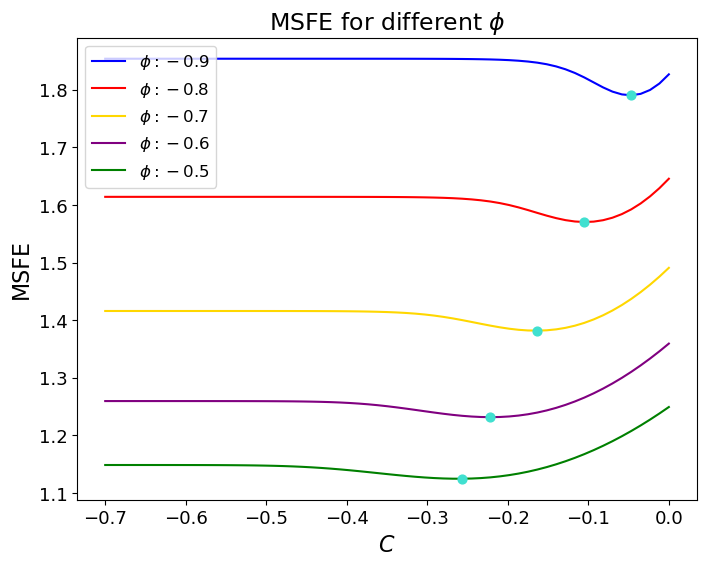

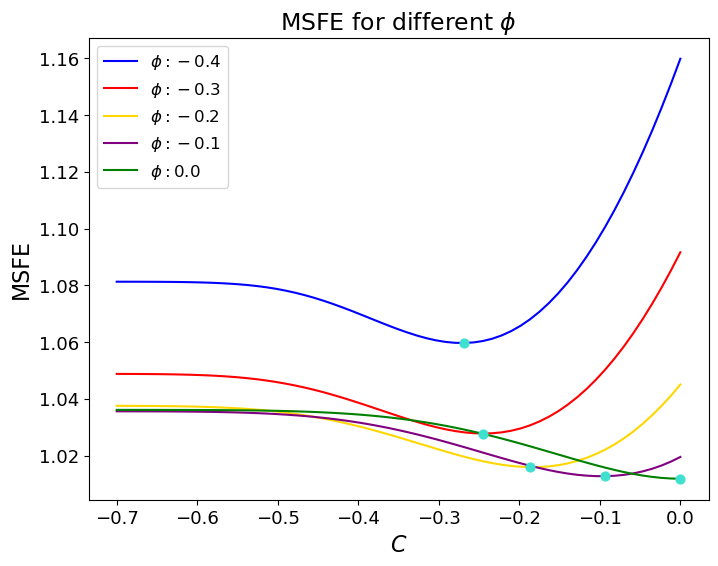

In [211]:
plot_multl_msfe(Mmsfe1,c2,phi1,1)
plot_multl_msfe(Mmsfe2,c2,phi2,2)

This plot is discussed in detail in the thesis